<a href="https://colab.research.google.com/github/spr-att/spra-tt.github.io/blob/main/AMLProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
np.random.seed(123)

**Question 1:**
Finish the noisy sine wave example introduced in class by fitting different polynomial models and determining what is the best degree.  Include a plot of the data and the fitted polynomial model; report the coefficient of determination.

In [ ]:
x = np.linspace(0,np.pi,50)
epsilon = np.random.normal(scale=0.2,size=x.shape)
y = np.sin(4*x) + epsilon

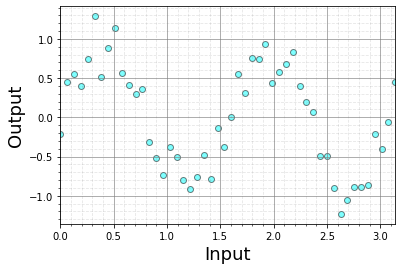

In [ ]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (6,6) # here we setup a desired figure size.
ax.scatter(x,y,ec='k',color='cyan',alpha=0.5) # we generate a scatter plot of x and y
ax.set_xlim([0,np.pi]) # we set the bounds for the horizontal axis
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Output',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
# create polynomial features and "guess" the best degree for this example
poly = PolynomialFeatures(degree=5)
x_poly = poly.fit_transform(x.reshape((-1,1))) # in x_poly we get the polynomial features

In [ ]:
# the model created is linear in weights 
model = LinearRegression()
model.fit(x_poly, y) # so we fit linear regression of polynomial features
y_poly_pred = model.predict(x_poly)

In [ ]:
r2 = r2_score(y,y_poly_pred)
print(r2)

0.8273496906692706


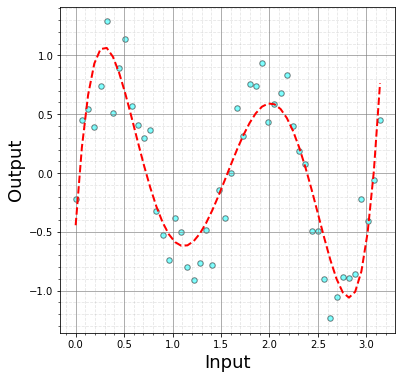

In [ ]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (6,6)
ax.scatter(x, y, s=30,ec='k',color='cyan',alpha=0.5)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x_sorted, y_poly_pred = zip(*sorted_zip)
ax.plot(x_sorted, y_poly_pred, color='r',linestyle='--',lw=2)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Output',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

**Answer:**
Above is a plot of the data showing the fitted polynomial model. There was a dramatic increase in the coefficient of determination from degree 4 to 5. Making 5 the best degree for this data with a (rounded) coefficient of determination of 0.82735.

**Question 2:**
Import (including the correct names of the variables) the data from the QSAR Fish Toxicity research. On the webpage you will find a description of the explanatory variables and the response (dependent) variable. Implement 10-fold cross validations and the correct data preprocessing, make polynomial models of degree 1, 2 and 3 and determine which degree achieves the best external validation.  For this, you will use the regularized regression models such as Ridge, Lasso and ElasticNet and you will also determine the best value of the hyperparameter alpha. In the case of ElasticNet, the second hyperparameter, L1 ratio, can be assumed to be 0.5.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
fish_data = pd.read_csv('gdrive/MyDrive/AML/qsar_fish_toxicity_edit.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
fish_data

,All
0,3.26;0.829;1.676;0;1;1.453;3.770
1,2.189;0.58;0.863;0;0;1.348;3.115
2,2.125;0.638;0.831;0;0;1.348;3.531
3,3.027;0.331;1.472;1;0;1.807;3.510
4,2.094;0.827;0.86;0;0;1.886;5.390
...,...
903,2.801;0.728;2.226;0;2;0.736;3.109
904,3.652;0.872;0.867;2;3;3.983;4.040
905,3.763;0.916;0.878;0;6;2.918;4.818
906,2.831;1.393;1.077;0;1;0.906;5.317


In [ ]:
fish_data[['CIC0','SM1_Dz(Z)','GATS1i','NdsCH','NdssC','MLOGP','LC50']] = fish_data['All'].str.split(';',expand=True)
fish_data = fish_data.drop(columns = ['All'])
fish_data

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
0,3.26,0.829,1.676,0,1,1.453,3.770
1,2.189,0.58,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.86,0,0,1.886,5.390
...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109
904,3.652,0.872,0.867,2,3,3.983,4.040
905,3.763,0.916,0.878,0,6,2.918,4.818
906,2.831,1.393,1.077,0,1,0.906,5.317


In [ ]:
#input correct variable names (identify explanatory and response variables)
#6 molecular descriptors and 1 quantitative experimental response:
#1) CIC0
#2) SM1_Dz(Z)
#3) GATS1i
#4) NdsCH
#5) NdssC
#6) MLOGP
#7) quantitative response, LC50 [-LOG(mol/L)]

In [ ]:
# extract x and y
x = fish_data.loc[:,'CIC0':'MLOGP'].values
y = fish_data['LC50'].values

In [ ]:
# we need a funciton defined that will perform KFold
kf = KFold(n_splits=10,shuffle=True,random_state=123)
#create pipeline function
scale = StandardScaler()
poly = PolynomialFeatures(degree=2)
pipe = Pipeline([['Scaler',scale],['Polynomial Features',poly]])

In [ ]:
# we need the actual cross- validations
score_train = []
score_test = []
#model = Ridge(alpha=0.5,fit_intercept=False)
#model = Lasso(alpha=0.01,fit_intercept=False)
model = ElasticNet(alpha = 0.01, fit_intercept=False)

for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  xtest = x[idxtest]
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  # here we apply the pipeline
  xpolytrain = pipe.fit_transform(xtrain)
  xpolytest = pipe.transform(xtest)
  model.fit(xpolytrain,ytrain)
  score_train.append(model.score(xpolytrain,ytrain))
  score_test.append(model.score(xpolytest,ytest))

**Ridge Model:**

In [ ]:
# Ridge with degree 1
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.5775775243391577
The external validation R2 score is : 0.5608669561823394


In [ ]:
# Ridge with degree 2, alpha = 0.01
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6264843232288264
The external validation R2 score is : 0.5666876561497886


In [ ]:
# Ridge with degree 2, alpha = 0.05
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.626484195162603
The external validation R2 score is : 0.5666895383484363


In [ ]:
## Best alpha and degree ##
# Ridge with degree 2, alpha = 0.5
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6264710871082877
The external validation R2 score is : 0.5666968547810682


In [ ]:
# Ridge with degree 2, alpha = 0.1
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.626483795388108
The external validation R2 score is : 0.5666916063128937


In [ ]:
# Ridge with degree 2, alpha = 1
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6264317965151833
The external validation R2 score is : 0.5666756350295151


In [ ]:
# Ridge with degree 3
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.7147484929390813
The external validation R2 score is : 0.38114004578816874


**Lasso Model:**

In [ ]:
# Lasso with degree 1
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.5772965007255885
The external validation R2 score is : 0.560868987869644


In [ ]:
## Best alpha and degree ##
# Lasso with degree 2, alpha = 0.01
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6234911332892903
The external validation R2 score is : 0.577527901610458


In [ ]:
# Lasso with degree 2, alpha = 0.05
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6010922769042617
The external validation R2 score is : 0.5654063672218317


In [ ]:
# Lasso with degree 3
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6984660110556208
The external validation R2 score is : 0.5378464697451799


**ElasticNet Model**

In [ ]:
# ElasticNet with degree 1
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.5771785098086142
The external validation R2 score is : 0.560923248719645


In [ ]:
## Best alpha and degree ##
# ElasticNet with degree 2, alpha = 0.01
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.6241609382216913
The external validation R2 score is : 0.5721267667369427


In [ ]:
# ElasticNet with degree 2, alpha = 0.05
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.5965510920703345
The external validation R2 score is : 0.5487381131294468


In [ ]:
# ElasticNet with degree 3
print('The internal validation R2 score is : ' +str(np.mean(score_train)))
print('The external validation R2 score is : ' +str(np.mean(score_test)))

The internal validation R2 score is : 0.7043582836296391
The external validation R2 score is : 0.5009396936364666


**Answer:** The best degree for all three models was **degree = 2**. The alpha that achieved the best external validation for Ridge regression was 0.5, for Lasso it was 0.01, and for ElasticNet it was also 0.01. The highest external validation came from the Lasso model.

Ridge external validation: 0.5666968547810682

**Lasso external validation: 0.577527901610458**

ElasticNet external validation: 0.5721267667369427